In [23]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [24]:
%matplotlib inline

In [50]:
def recolour_image(before, bgr=[1.5, 0.75, 1.25]):
    """
    Recolour greyscale image `before` to new colour `bgr`
    in blue-green-red format
    
    Adapted from: https://stackoverflow.com/a/58142700
    """
    
    before = cv2.cvtColor(before, cv2.COLOR_GRAY2BGR)
    b, g, r = cv2.split(before)

    np.multiply(b, bgr[0], out=b, casting="unsafe")
    np.multiply(g, bgr[1], out=g, casting="unsafe")
    np.multiply(r, bgr[2], out=r, casting="unsafe")

    after = cv2.merge([b, g, r])
    
    return after


def overlay_images_horizontal(img1, img2, translation):
    """
    Recolour two greyscale images to red and green,
    overlay with 50% transparency
    """
    
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img_1 = recolour_image(img1, bgr=[0, 0, 255])
    # img_180 = np.fliplr(recolour_image(img2, bgr=[0, 255, 0]))
    img_2 = recolour_image(img2, bgr=[0, 255, 0])
    img_2_shift = cv2.warpAffine(img_2, M, (img_2.shape[1], img_2.shape[0]))
    blended = cv2.addWeighted(img_1, 0.5, img_2_shift, 0.5, 0.0)
    blended = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    
    return blended

def overlay_images_vertical(img1, img2, translation):
    """
    Recolour two greyscale images to red and green,
    overlay with 50% transparency
    """
    
    M = np.float32([
        [1, 0, 0],
        [0, 1, translation]
    ])
    
    img_1 = recolour_image(img1, bgr=[0, 0, 255])
    # img_180 = np.fliplr(recolour_image(img2, bgr=[0, 255, 0]))
    img_2 = recolour_image(img2, bgr=[0, 255, 0])
    img_2_shift = cv2.warpAffine(img_2, M, (img_2.shape[1], img_2.shape[0]))
    blended = cv2.addWeighted(img_1, 0.5, img_2_shift, 0.5, 0.0)
    blended = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    
    return blended


def overlay_images_total(img1, img2, h_shift, v_shift):
    """
    Recolour two greyscale images to red and green,
    overlay with 50% transparency
    """
    
    M = np.float32([
        [1, 0, h_shift],
        [0, 1, v_shift]
    ])
    
    img_1 = recolour_image(img1, bgr=[0, 0, 255])
    # img_180 = np.fliplr(recolour_image(img2, bgr=[0, 255, 0]))
    img_2 = recolour_image(img2, bgr=[0, 255, 0])
    img_2_shift = cv2.warpAffine(img_2, M, (img_2.shape[1], img_2.shape[0]))
    blended = cv2.addWeighted(img_1, 0.5, img_2_shift, 0.5, 0.0)
    blended = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    
    return blended


def subtract_images_horizontal(img1, img2, translation):
    """
    Translate second image relative to first, and subtract
    """
    
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    # img2 = np.fliplr(img2)
    img_2_shift = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    subtracted = cv2.subtract(img1, img_2_shift)
    
    return subtracted


def subtract_images_vertical(img1, img2, translation):
    """
    Translate second image relative to first, and subtract
    """
    
    M = np.float32([
        [1, 0, 0],
        [0, 1, translation]
    ])
    
    # img2 = np.fliplr(img2)
    img_2_shift = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    subtracted = cv2.subtract(img1, img_2_shift)
    
    return subtracted


def misalignment_horizontal(img1, img2, offset):
    """
    Return sum of intensity in central half of difference 
    between two images, as measure of misalignment
    """
    
    x = subtract_images_horizontal(img1, img2, offset)
    width = np.shape(x)[1]
    intensity = np.concatenate(x[:,width//4:width*3//4]).sum()
    
    return intensity

def misalignment_vertical(img1, img2, offset):
    """
    Return sum of intensity in central half of difference 
    between two images, as measure of misalignment
    """
    
    x = subtract_images_vertical(img1, img2, offset)
    height = np.shape(x)[0]
    intensity = np.concatenate(x[:,height//4:height*3//4]).sum()
    
    return intensity



def align_images_debug_horizontal(img1, img2, frac=4):
    """
    Slide two images past each other and find offset which minimises misalignment
    """

    width = img1.shape[1]
    frac = frac  # decreasing factor tries larger range of offsets
    offsets = np.arange(
        -width // frac, width // frac
    )  # working with integer offsets only
    misalignments = [misalignment_horizontal(img1, img2, i) for i in tqdm(offsets, desc='Horizontal alignment: ')]
    stack = np.column_stack((offsets, misalignments))
    optimal = stack[np.argmin(stack[:, 1]), 0]

    return optimal, offsets, misalignments


def align_images_debug_vertical(img1, img2, frac=4):
    """
    Slide two images past each other and find offset which minimises misalignment
    """

    height = img1.shape[0]
    frac = frac  # decreasing factor tries larger range of offsets
    offsets = np.arange(
        -height // frac, height // frac
    )  # working with integer offsets only
    misalignments = [misalignment_vertical(img1, img2, i) for i in tqdm(offsets, desc='Vertical alignment: ')]
    stack = np.column_stack((offsets, misalignments))
    optimal = stack[np.argmin(stack[:, 1]), 0]

    return optimal, offsets, misalignments


def plot_alignment_debug(img1, img2, frac=4):
    """
    Split image, align front and back projections, and plot
    """

    optimal_h, offsets_h, misalignments_h = align_images_debug_horizontal(img1, img2, frac)
    f, axes = plt.subplots(1, 6, figsize=(20, 4))
    axes[0].imshow(overlay_images_horizontal(img1, img2, 0).astype(np.uint8))  # rescale to [0,255]
    axes[0].set_title("Original")
    axes[1].imshow(overlay_images_horizontal(img1, img2, optimal_h).astype(np.uint8))
    axes[1].set_title(f"Horizontally aligned (offset {int(optimal_h)} px)")
    optimal_v, offsets_v, misalignments_v = align_images_debug_vertical(img1, img2, frac)
    axes[2].imshow(overlay_images_vertical(img1, img2, optimal_v).astype(np.uint8))
    axes[2].set_title(f"Vertically aligned (offset {int(optimal_v)} px)")
    axes[3].imshow(overlay_images_total(img1, img2, optimal_h, optimal_v).astype(np.uint8))
    axes[3].set_title(f"Fully aligned")
    axes[4].plot(offsets_h, misalignments_h)
    axes[4].set_xlabel('offset')
    axes[4].set_ylabel('misalignment (intensity)')
    axes[4].set_title('horizontal minimisation curve')
    axes[5].plot(misalignments_v, offsets_v)
    axes[5].set_ylabel('offset')
    axes[5].set_xlabel('misalignment (intensity)')
    axes[5].set_title('vertical minimisation curve')
    plt.tight_layout()
    plt.show()

    return offsets_h, misalignments_h, offsets_v, misalignments_v


def align_stack(filename):
    im = io.imread(filename)
    imgs = list(np.arange(0, im.shape[2]))
    for a, b in zip(imgs, imgs[1:]):
        print(f'Aligning image {a} vs {b}')
        img1 = im[:, :, a]
        img2 = im[:, :, b]
        offsets_h, misalignments_h, offsets_v, misalignments_v = plot_alignment_debug(img1, img2)

Aligning image 0 vs 1


Vertical alignment: 100%|██████████| 696/696 [00:06<00:00, 100.73it/s]


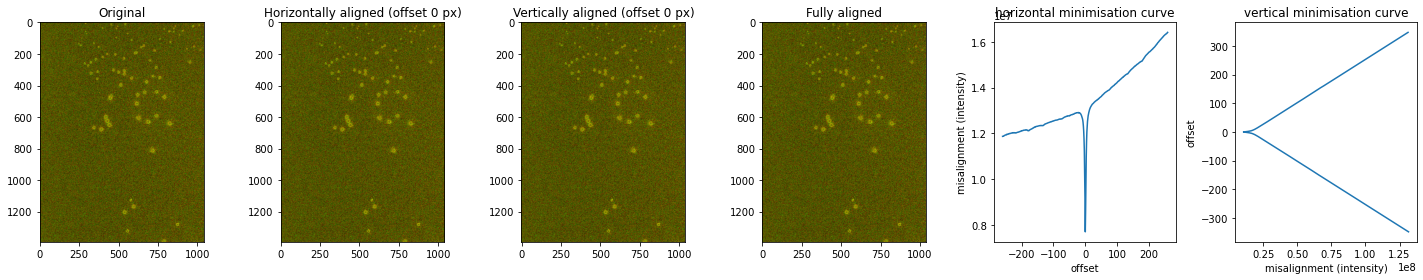

Aligning image 1 vs 2


Vertical alignment: 100%|██████████| 696/696 [00:06<00:00, 103.14it/s]


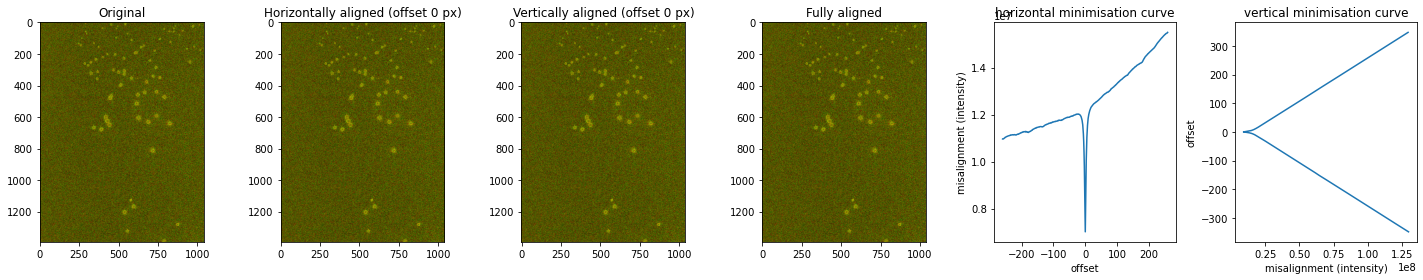

Aligning image 2 vs 3


Vertical alignment: 100%|██████████| 696/696 [00:06<00:00, 106.36it/s]


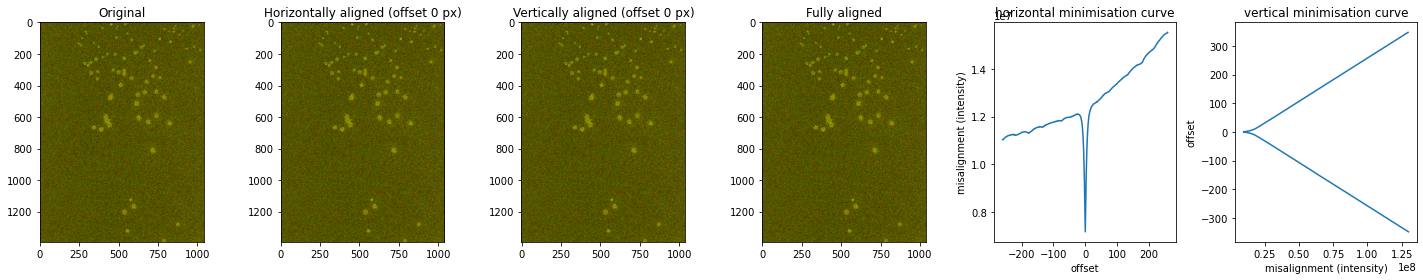

In [51]:
align_stack('../../data_store/2023-03-01 focal scanning first projections.tif')

Aligning image 0 vs 1


Vertical alignment: 100%|██████████| 696/696 [00:06<00:00, 108.72it/s]


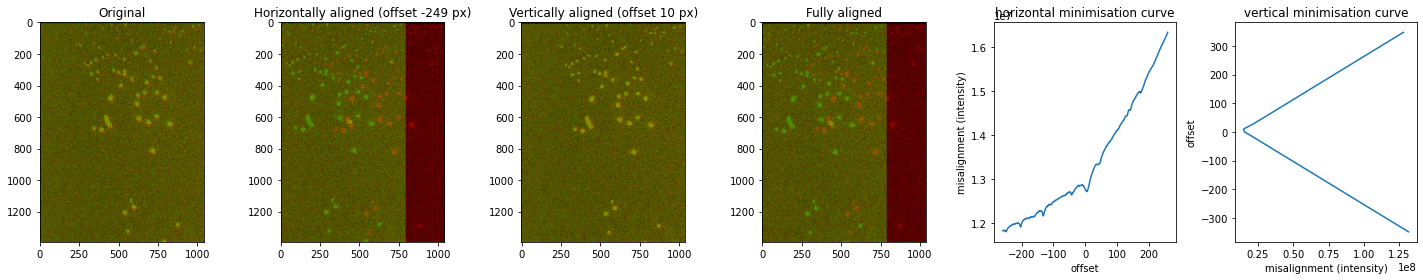

Aligning image 1 vs 2


Vertical alignment: 100%|██████████| 696/696 [00:06<00:00, 107.19it/s]


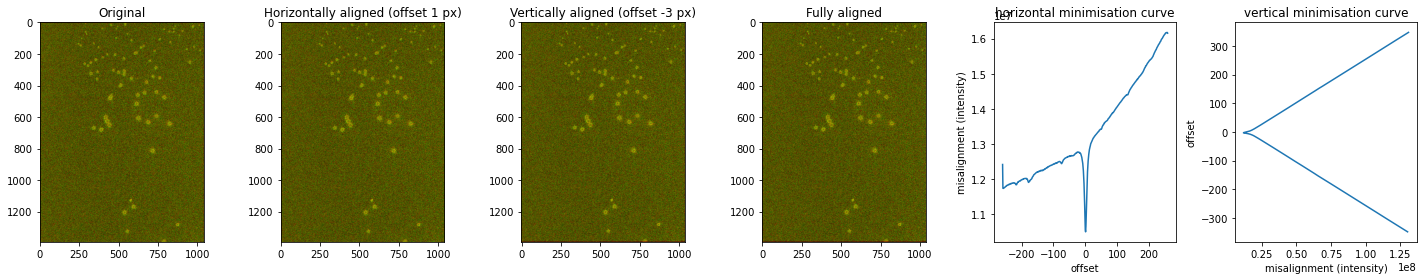

Aligning image 2 vs 3


Vertical alignment: 100%|██████████| 696/696 [00:06<00:00, 106.92it/s]


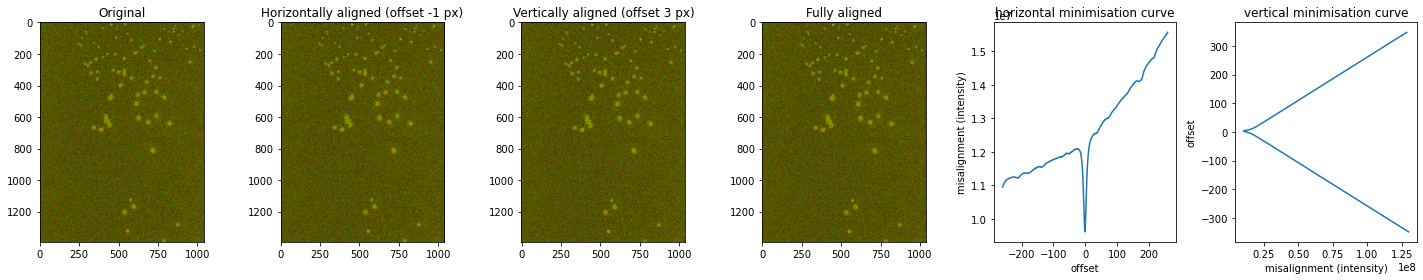

In [52]:
align_stack('../../data_store/2023-03-01 focal scanning first projections_misaligned.tif')